In [1]:
import os
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.{ext}")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False)
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["mjd", "imagetyp", "spec", "camera", "expnum", "exptime", "neon", "hgne", "xenon", "argon", "ldls"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
mjds = np.unique(unique_groups["mjd"])
cameras = ["b", "r", "z"]
spec = 1
for mjd, camera in it.product(mjds, cameras):
    biases = frames_groups[(unique_groups["mjd"]==mjd)&(unique_groups["imagetyp"]=="bias")&(unique_groups["spec"]==f"sp{spec}")&(unique_groups["camera"]==f"{camera}{spec}")]
    biases.pprint(max_width=200)
    
    # let's pre-process the all bias frames
    pbias_paths = []
    for bias_frame in biases:
        bias_path = bias_frame["path"]
        bias_camera, bias_expnum = bias_frame["camera"], bias_frame["expnum"]

        pbias_path = out_main_path.format(kind="pbias", camera=bias_camera, expnum=bias_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=bias_path,
            out_image=pbias_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        pbias_paths.append(pbias_path)

    print(mjd)
    print(pbias_paths)
    if pbias_paths:
        imageMethod.createMasterFrame_drp(
            in_images=pbias_paths,
            out_image=out_calib_path.format(mjd=mjd, kind="mbias", camera=bias_camera, exptime=int(bias_frame["exptime"]), ext="fits")
        )

imagetyp spec  mjd  camera  expnum  exptime argon  neon  ldls  hgne xenon                                                           path                                                          
-------- ---- ----- ------ -------- ------- ----- ----- ----- ----- ----- ------------------------------------------------------------------------------------------------------------------------
    bias  sp1 60009     b1 00000025     0.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000025.fits.gz
    bias  sp1 60009     b1 00000028     0.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000028.fits.gz
    bias  sp1 60009     b1 00000035     0.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000035.fits.gz
[INFO]: using given overs

In [5]:
mjds = np.unique(unique_groups["mjd"])
cameras = ["b", "r", "z"]
spec = 1
for mjd, camera in it.product(mjds, cameras):
    darks = frames_groups[(unique_groups["mjd"]==mjd)&(unique_groups["imagetyp"]=="dark")&(unique_groups["spec"]==f"sp{spec}")&(unique_groups["camera"]==f"{camera}{spec}")]
    darks.pprint(max_width=200)
    
    # let's pre-process the all dark frames
    pdark_paths = []
    for dark_frame in darks:
        dark_path = dark_frame["path"]
        dark_camera, dark_expnum = dark_frame["camera"], dark_frame["expnum"]

        pdark_path = out_main_path.format(kind="pdark", camera=dark_camera, expnum=dark_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=dark_path,
            out_image=pdark_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        pdark_paths.append(pdark_path)

    print(mjd)
    print(pdark_paths)
    if pdark_paths:
        imageMethod.createMasterFrame_drp(
            in_images=pdark_paths,
            out_image=out_calib_path.format(mjd=mjd, kind="mdark", camera=dark_camera, exptime=int(dark_frame["exptime"]), ext="fits"),
        )

imagetyp spec  mjd  camera  expnum  exptime argon  neon  ldls  hgne xenon                                                           path                                                          
-------- ---- ----- ------ -------- ------- ----- ----- ----- ----- ----- ------------------------------------------------------------------------------------------------------------------------
    dark  sp1 60009     b1 00000009    60.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000009.fits.gz
    dark  sp1 60009     b1 00000010    60.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000010.fits.gz
    dark  sp1 60009     b1 00000011    60.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60009/sdR-s-b1-00000011.fits.gz
    dark  sp1 60009     b

In [33]:
cameras = ["b", "r", "z"]
spec = 1
for camera in cameras:
    fiberflats = frames_groups[(unique_groups["mjd"]==60041)&(unique_groups["ldls"])&(unique_groups["camera"]==f"{camera}{spec}")]
    fiberflats.pprint(max_width=200)
    
    # let's pre-process the all fiberflat frames
    cfiberflat_paths = []
    for fiberflat_frame in fiberflats:
        fiberflat_path = fiberflat_frame["path"]
        fiberflat_camera, fiberflat_expnum, fiberflat_exptime = fiberflat_frame["camera"], fiberflat_frame["expnum"], fiberflat_frame["exptime"]

        pfiberflat_path = out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=fiberflat_path,
            out_image=pfiberflat_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        # imageMethod.LACosmic_drp(
        #     in_image=out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        #     out_image=out_main_path.format(kind="rfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
        # )
        cfiberflat_path = out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits")
        imageMethod.basicCalibration_drp(
            in_image=out_main_path.format(kind="pfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
            out_image=cfiberflat_path,
            in_bias=out_calib_path.format(mjd=60039, kind="mbias", camera=fiberflat_camera, exptime=0, ext="fits"),
            # in_dark=out_calib_path.format(mjd=60039, kind="mdark", camera=fiberflat_camera, exptime=60, ext="fits")
        )
        cfiberflat_paths.append(cfiberflat_path)

    if cfiberflat_paths:
        print(cfiberflat_paths)
        imageMethod.combineImages_drp(
            images=",".join(cfiberflat_paths),
            out_image=out_main_path.format(kind="mfiberflat", camera=fiberflat_camera, expnum="ldls", ext="fits"),
            method="median"
        )

imagetyp spec  mjd  camera  expnum  exptime argon  neon ldls  hgne xenon                                                           path                                                          
-------- ---- ----- ------ -------- ------- ----- ----- ---- ----- ----- ------------------------------------------------------------------------------------------------------------------------
  object  sp1 60041     b1 00000694    30.0 False False True False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-b1-00000694.fits.gz
  object  sp1 60041     b1 00000695    90.0 False False True False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-b1-00000695.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRIMSEC' YX_i = (['1', '4080'], ['1', '2043']), YX_f = (['1', '4080'], ['2078', '4120'])
[INFO]: median counts in overscan sect

[INFO]: selecting column = 1870 to locate fibers
[INFO]: locating fibers
[INFO]: found 636 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 636


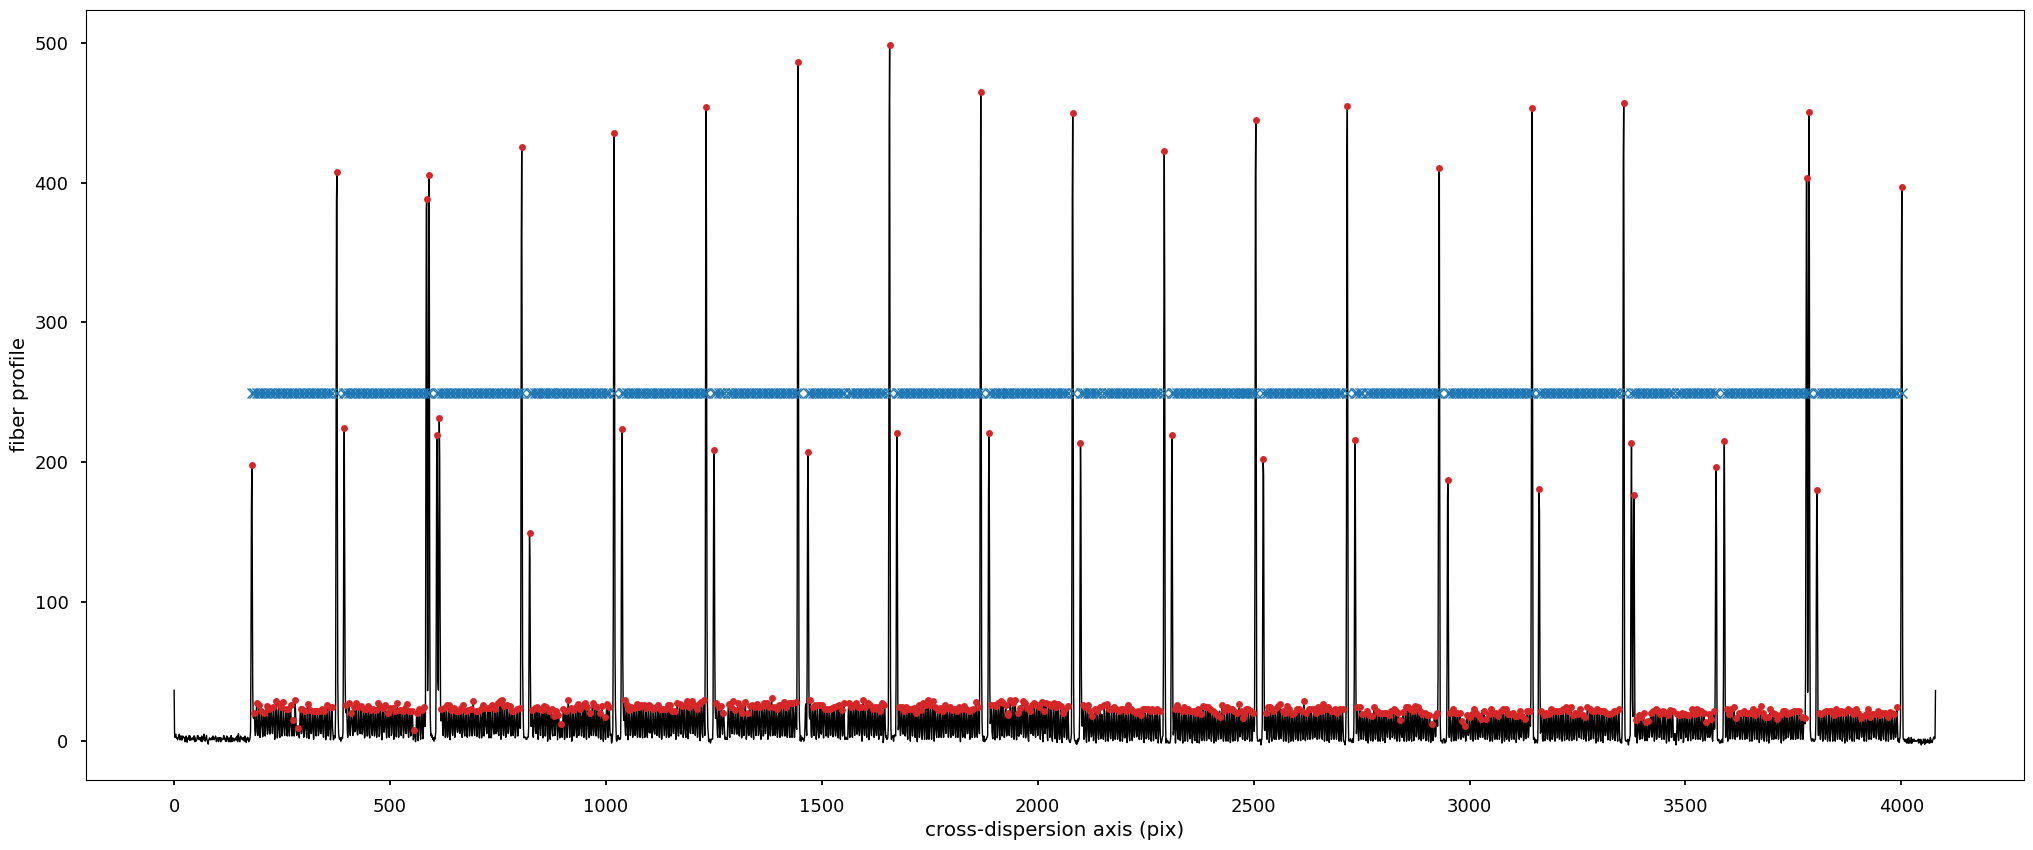

[INFO]: tracing fibers along dispersion axis


tracing fiber left from pixel 1870: 100%|########################################################| 1870/1870 [00:00<00:00, 1930.91pixel/s]


[WARNING]: invalid value encountered in divide (RuntimeWarning)


tracing fiber right from pixel 1870: 100%|#######################################################| 2215/2215 [00:01<00:00, 1711.45pixel/s]


[INFO]: fitting trace with 2-deg polynomial
[INFO]: selecting column = 1880 to locate fibers
[INFO]: locating fibers
[INFO]: found 635 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 635


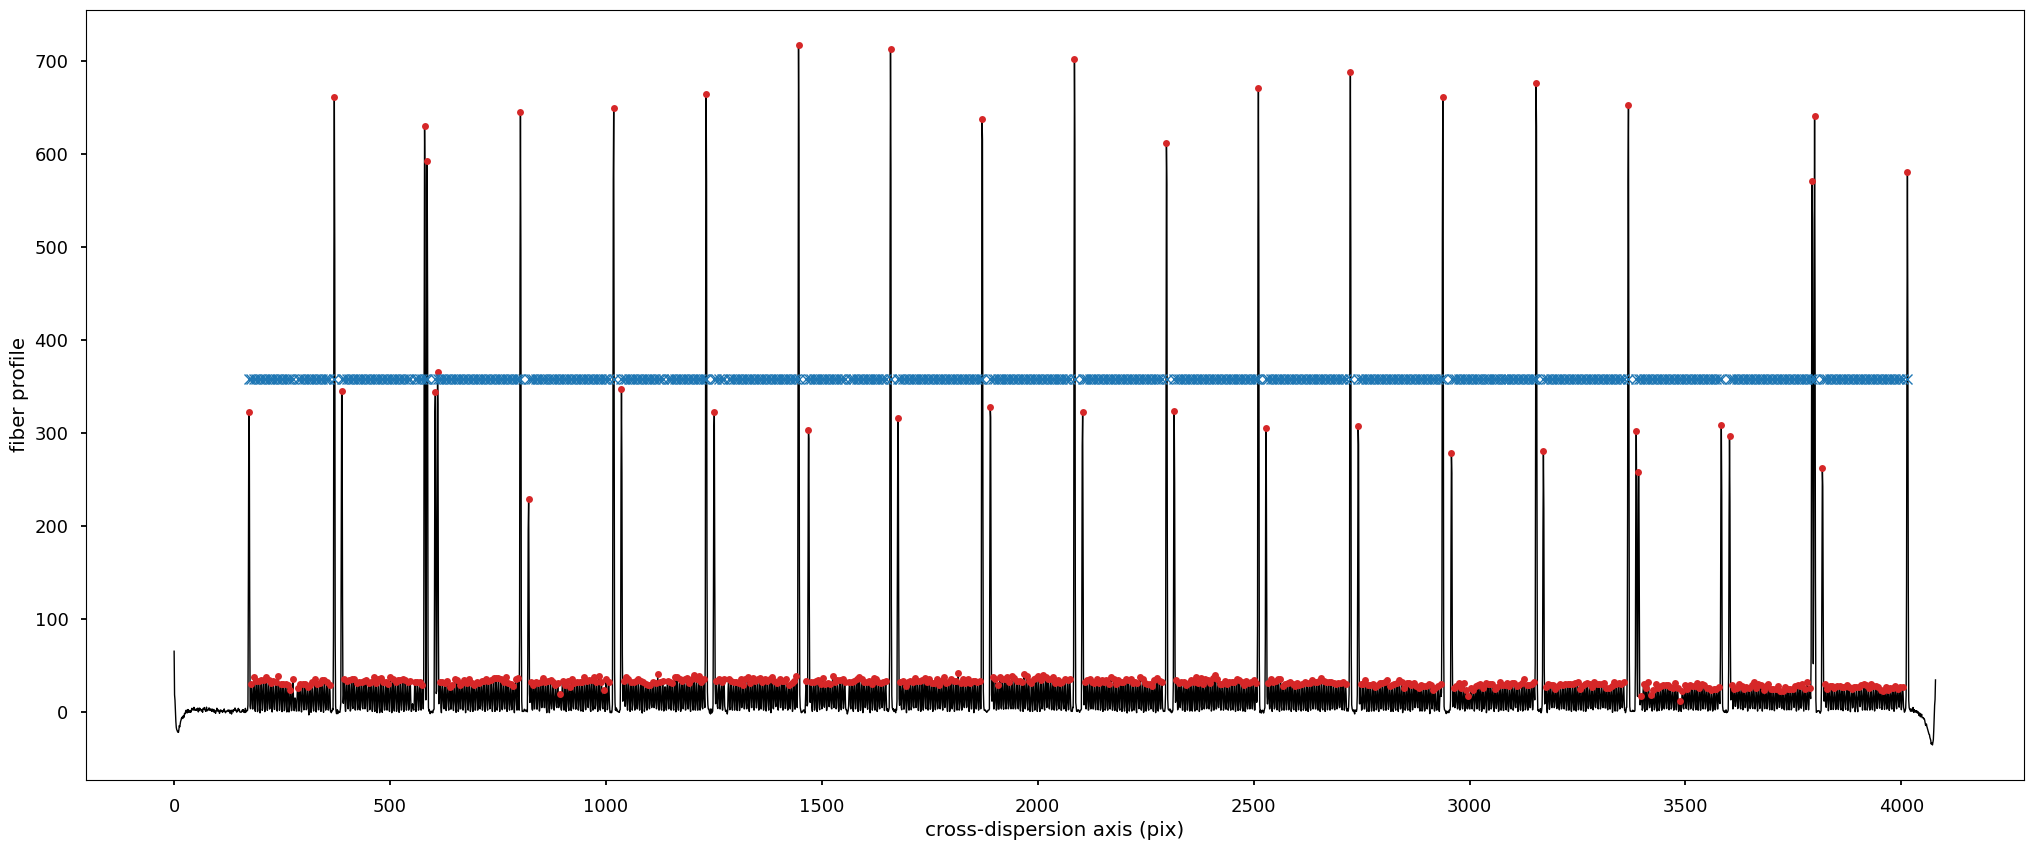

[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 1880: 100%|########################################################| 2205/2205 [00:02<00:00, 980.11pixel/s]


[INFO]: fitting trace with 2-deg polynomial
[INFO]: selecting column = 1850 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


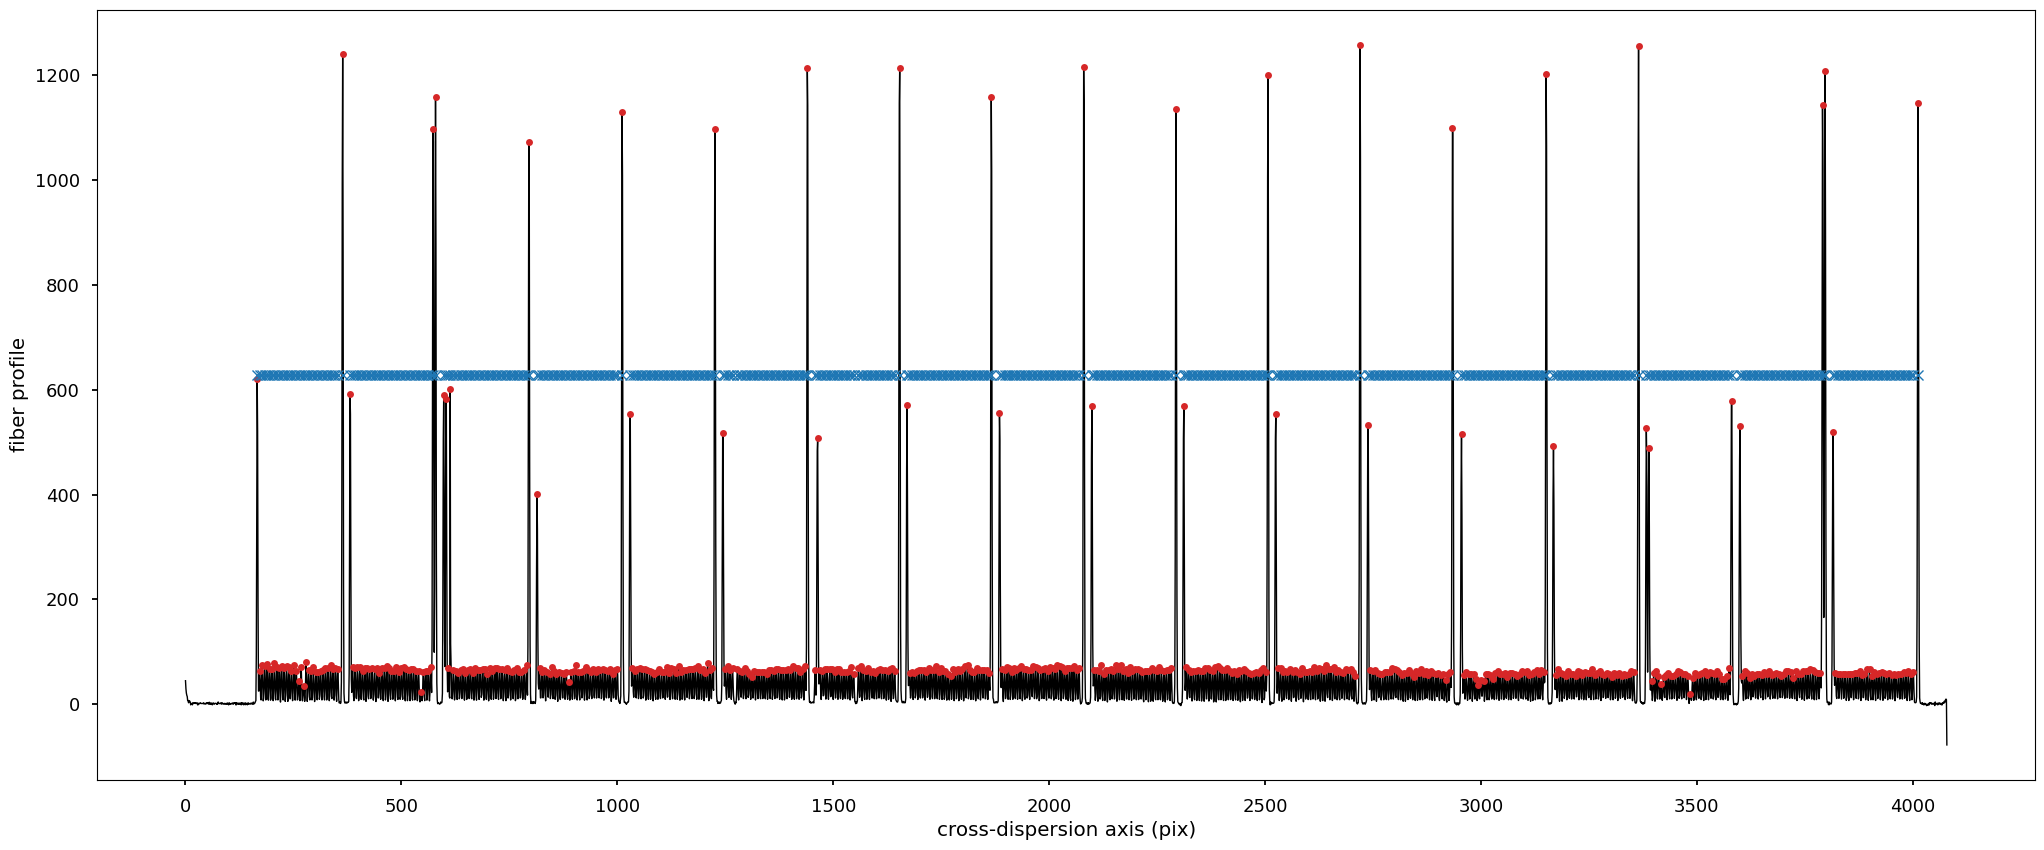

[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 1850: 100%|########################################################| 2235/2235 [00:02<00:00, 789.38pixel/s]


[INFO]: fitting trace with 2-deg polynomial


In [34]:
fiberflat_camera = "b1"

imageMethod.findPeaksAuto_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    nfibers=0, slice=1870, threshold=6, method="hyperbolic", median_box=5, median_cross=1, plot=1
)
imageMethod.tracePeaks_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-ldls.fits"),
    in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    steps=50, coadd=10, threshold_peak=10, max_diff=2, method="hyperbolic", median_box=5, median_cross=1, plot=1,
    poly_disp=2
)

fiberflat_camera = "r1"

imageMethod.findPeaksAuto_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    nfibers=0, slice=1880, threshold=10, method="hyperbolic", median_box=5, median_cross=1, plot=1
)
imageMethod.tracePeaks_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-ldls.fits"),
    in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    steps=50, coadd=10, threshold_peak=10, max_diff=2, method="hyperbolic", median_box=5, median_cross=1, plot=1,
    poly_disp=2
)

fiberflat_camera = "z1"

imageMethod.findPeaksAuto_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    nfibers=0, slice=1850, threshold=10, method="hyperbolic", median_box=5, median_cross=1, plot=1
)
imageMethod.tracePeaks_drp(
    in_image=os.path.join(output_path, f"lvm-mfiberflat-{fiberflat_camera}-ldls.fits"),
    out_trace=os.path.join(output_path, f"lvm-trace-{fiberflat_camera}-ldls.fits"),
    in_peaks=os.path.join(output_path, f"lvm-peaks-{fiberflat_camera}-ldls.txt"),
    steps=50, coadd=10, threshold_peak=10, max_diff=2, method="hyperbolic", median_box=5, median_cross=1, plot=1,
    poly_disp=2
)

In [35]:
df = frames_table.to_pandas()
print(df.query("(neon|hgne|argon) & mjd == 60041 & spec == 'sp1'").sort_values("expnum").to_string())

     imagetyp spec    mjd camera    expnum  exptime  argon   neon   ldls   hgne  xenon                                                                                                                      path
1608   object  sp1  60041     b1  00000684    270.0   True  False  False  False  False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-b1-00000684.fits.gz
1636   object  sp1  60041     r1  00000684    270.0   True  False  False  False  False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-r1-00000684.fits.gz
1664   object  sp1  60041     z1  00000684    270.0   True  False  False  False  False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-z1-00000684.fits.gz
1611   object  sp1  60041     b1  00000687    270.0  False   True  False  False  False  /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/

In [36]:
cameras = ["b", "r", "z"]
spec = 1
for camera in cameras:
    arcs = frames_groups[(unique_groups["mjd"]==60041)&(unique_groups["neon"])&(unique_groups["camera"]==f"{camera}{spec}")]
    arcs.pprint(max_width=200)
    
    # let's pre-process the all arc frames
    xarc_paths = []
    for arc_frame in arcs:
        arc_path = arc_frame["path"]
        arc_camera, arc_expnum, arc_exptime = arc_frame["camera"], arc_frame["expnum"], arc_frame["exptime"]

        parc_path = out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits")

        imageMethod.preprocRawFrame_drp(
            in_image=arc_path,
            out_image=parc_path,
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077"
        )
        # imageMethod.LACosmic_drp(
        #     in_image=out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        #     out_image=out_main_path.format(kind="rarc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
        # )
        imageMethod.basicCalibration_drp(
            in_image=out_main_path.format(kind="parc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
            out_image=out_main_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
            in_bias=out_calib_path.format(mjd=60010, kind="mbias", camera=arc_camera, exptime=0, ext="fits"),
            in_dark=out_calib_path.format(mjd=60010, kind="mdark", camera=arc_camera, exptime=300, ext="fits")
        )
        
        xarc_path = out_main_path.format(kind="xarc", camera=arc_camera, expnum=arc_expnum, ext="fits")
        imageMethod.extractSpec_drp(
            in_image=out_main_path.format(kind="carc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
            out_rss=xarc_path,
            in_trace=out_main_path.format(kind="trace", camera=arc_camera, expnum="ldls", ext="fits"),
            method="aperture", aperture=4, plot=1, parallel="auto"
        )
        xarc_paths.append(xarc_path)

    lamps = list(filter(lambda c: np.sum(arcs[c]), ["neon", "hgne", "xenon", "argon"]))
    if xarc_paths:
        rssMethod.combineRSS_drp(
            in_rsss=",".join(xarc_paths),
            out_rss=out_main_path.format(kind="marc", camera=arc_camera, expnum="_".join(lamps), ext="fits"),
            method="median"
        )

imagetyp spec  mjd  camera  expnum  exptime argon neon  ldls  hgne xenon                                                           path                                                          
-------- ---- ----- ------ -------- ------- ----- ---- ----- ----- ----- ------------------------------------------------------------------------------------------------------------------------
  object  sp1 60041     b1 00000687   270.0 False True False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60041/sdR-s-b1-00000687.fits.gz
[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRIMSEC' YX_i = (['1', '4080'], ['1', '2043']), YX_f = (['1', '4080'], ['2078', '4120'])
[INFO]: median counts in overscan sections {'a': 995.0, 'b': 991.0, 'c': 988.0, 'd': 995.0}
[INFO]: standard deviation in overscan sections {'a': 1.3204763, 'b': 1.3286564, 'c': 1.144509, 'd': 1.168453}
[INFO]: extracted gain values

[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_b1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 19 percentage masked  10.5263 %
[INFO]: going to use 17 guess lines
[INFO]: reading arc from './data/lvm-marc-b1-neon.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = 1 pix
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1.0, fwhm_max = 10.0 and relative flux limits [0.001, 10.0]


measuring arc lines upwards from ref_fiber = 319:  52%|########################                      | 167/319 [00:03<00:04, 36.75fiber/s]

[WARNING]: Number of calls to function has reached maxfev = 9999. (RuntimeWarning)


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:08<00:00, 38.07fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 316/316 [00:09<00:00, 33.45fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 3-deg polynomials
[INFO]: fitting wavelength solutions using 3-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 0.081368 AA (0.137065 pix)
[INFO]: fitting LSF solutions using 3-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.104461 AA (0.181229 pix)


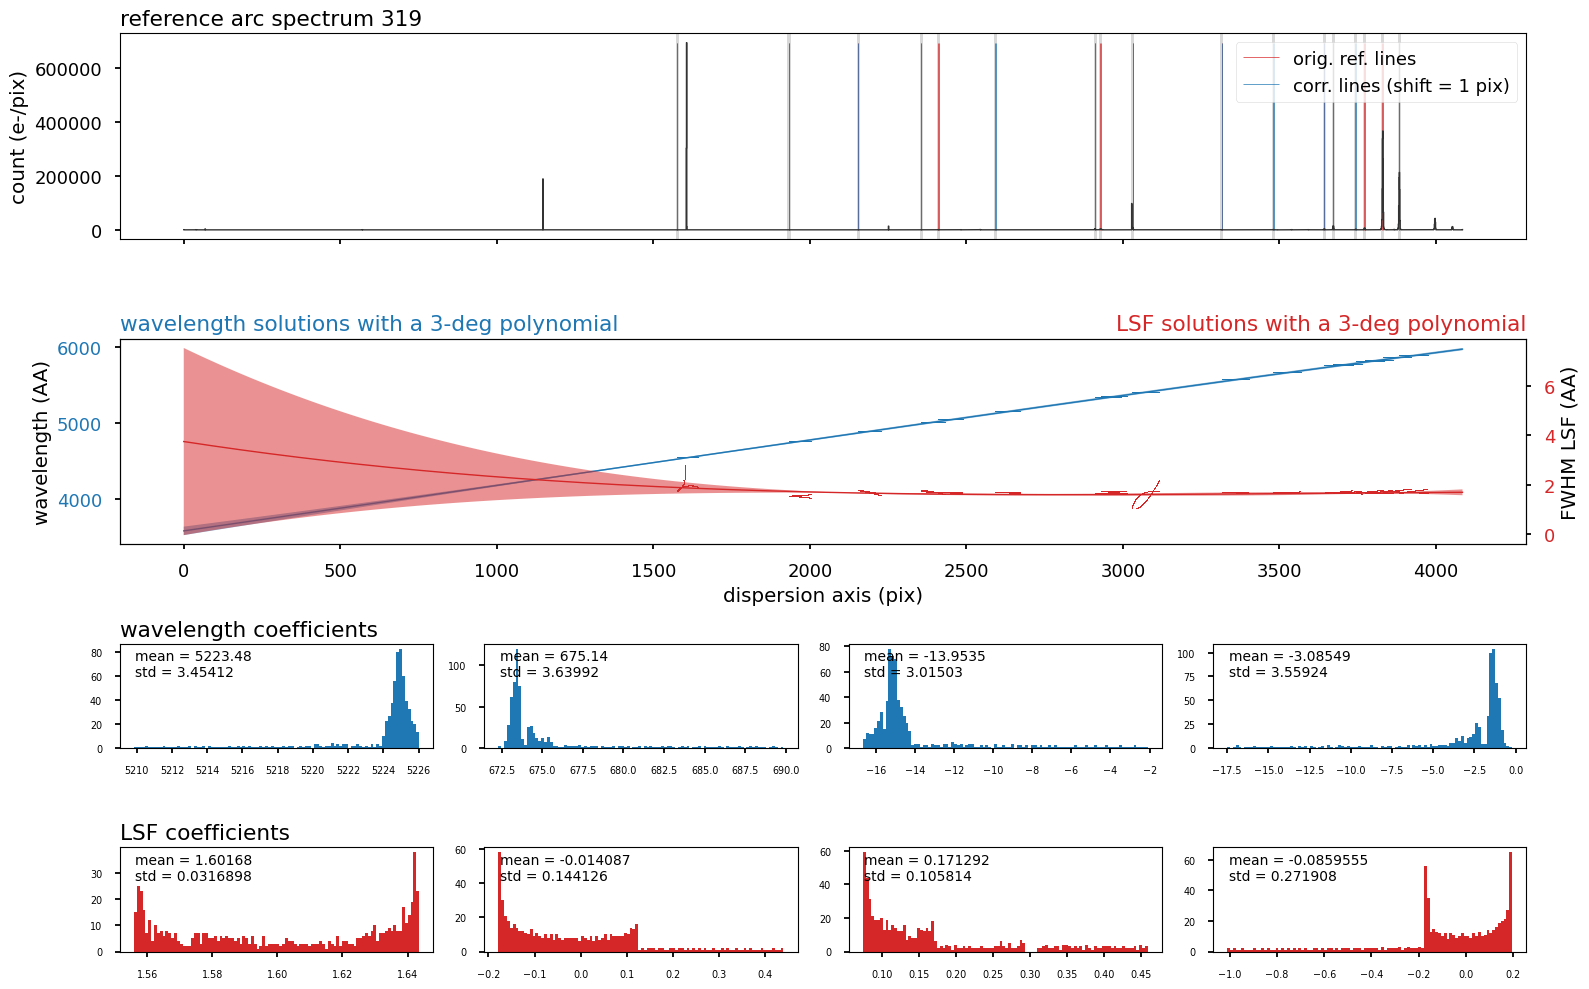

[INFO]: updating header and writing wavelength/LSF to './data/lvm-wave-b1-neon.fits' and './data/lvm-lsf-b1-neon.fits'
[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_r1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 27 percentage masked  7.40741 %
[INFO]: going to use 25 guess lines
[INFO]: reading arc from './data/lvm-marc-r1-neon.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = 0 pix
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1.0, fwhm_max = 10.0 and relative flux limits [0.001, 10.0]


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:57<00:00,  5.57fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 315/315 [01:09<00:00,  4.53fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 3-deg polynomials
[INFO]: fitting wavelength solutions using 3-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 1.28323 AA (2.43099 pix)
[INFO]: fitting LSF solutions using 3-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.59755 AA (1.13373 pix)


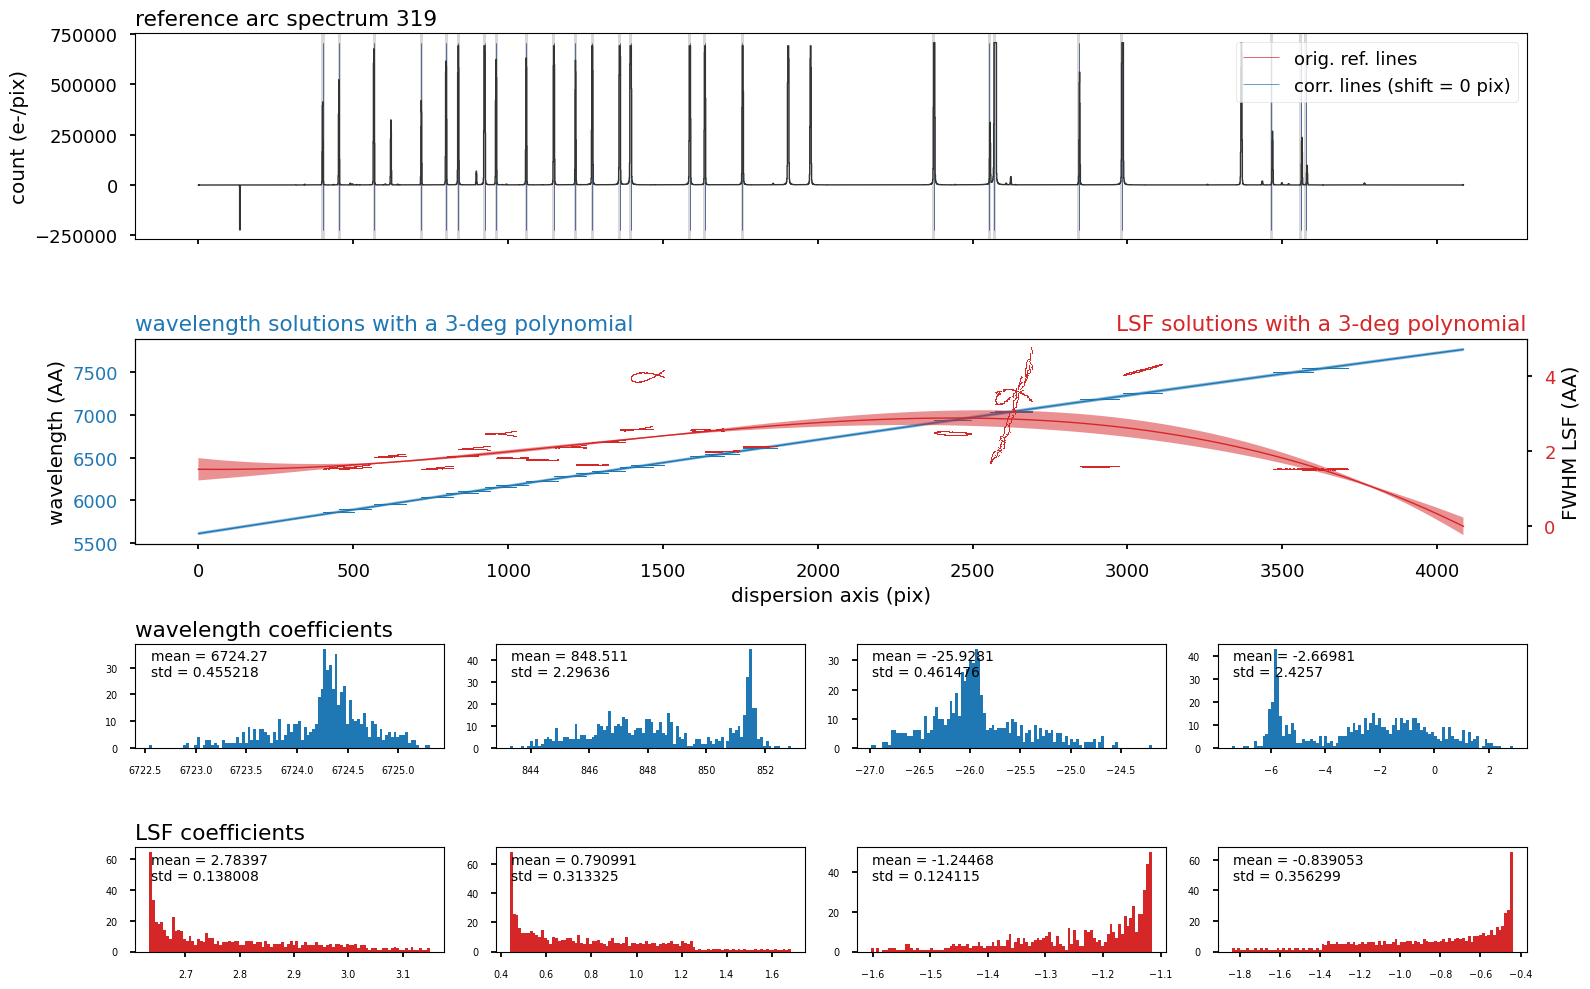

[INFO]: updating header and writing wavelength/LSF to './data/lvm-wave-r1-neon.fits' and './data/lvm-lsf-r1-neon.fits'
[INFO]: reading guess lines from '../../python/lvmdrp/etc/lvm-neon_nist_z1.txt'
[INFO]: going to use fiber 319 as reference
[INFO]: number of guess lines in file 26 percentage masked  19.2308 %
[INFO]: going to use 21 guess lines
[INFO]: reading arc from './data/lvm-marc-z1-neon.fits'
[INFO]: calculating shift in guess lines using CC
[INFO]: maximum CC shift = 0 pix
[INFO]: measuring arc lines for each fiber from reference fiber 319, flux_min = 1.0, fwhm_max = 10.0 and relative flux limits [0.001, 10.0]


measuring arc lines upwards from ref_fiber = 319: 100%|##############################################| 319/319 [00:07<00:00, 42.60fiber/s]
measuring arc lines downwards from ref_fiber = 319: 100%|############################################| 318/318 [00:07<00:00, 44.51fiber/s]


[INFO]: smoothing FWHM of guess lines along cross-dispersion axis using 3-deg polynomials
[INFO]: fitting wavelength solutions using 3-deg polynomials
[INFO]: finished wavelength fitting with median RMS = 0.12125 AA (0.203341 pix)
[INFO]: fitting LSF solutions using 3-deg polynomials
[INFO]: finished LSF fitting with median RMS = 0.159838 AA (0.262338 pix)


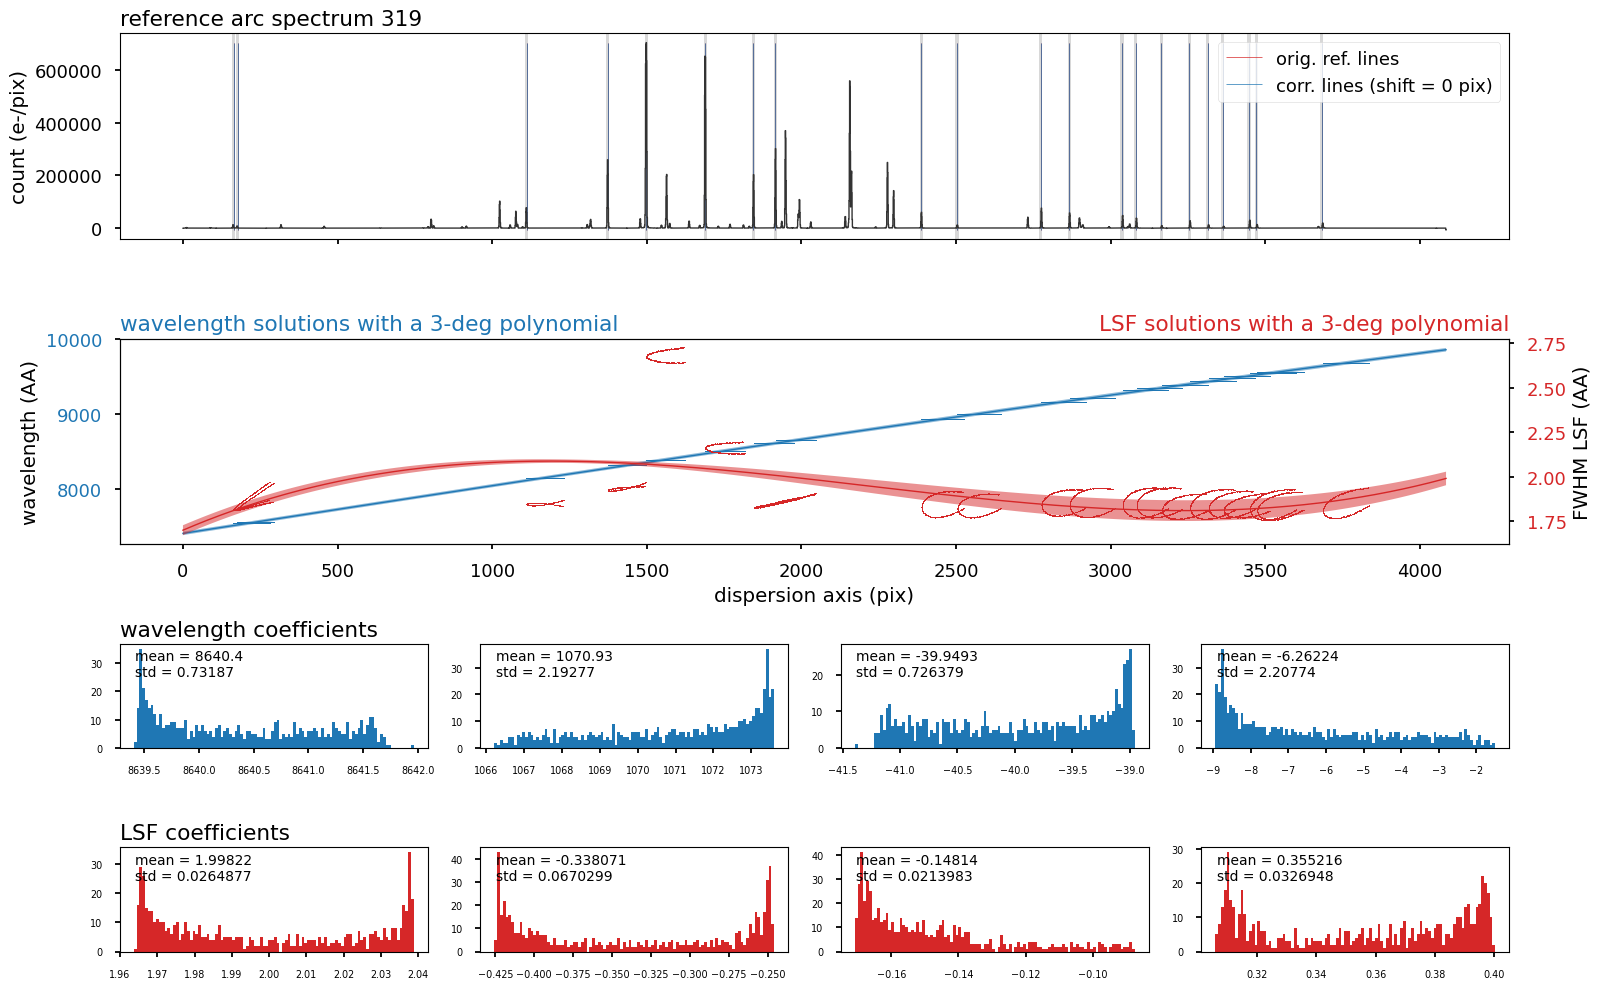

[INFO]: updating header and writing wavelength/LSF to './data/lvm-wave-z1-neon.fits' and './data/lvm-lsf-z1-neon.fits'


In [37]:
cameras = ["b", "r", "z"]
spec = 1
CHANNEL_WL = {"b1": (3600, 5930), "r1": (5660, 7720), "z1": (7470, 9800)}
ised = 319
coad = 5
lamps = "neon"
# arc_expnum = "00000687"
arc_expnum = "neon"
kind = "marc"

# in the wavelength diagnostic plots, remove the linear component

for camera in cameras:
    arc_camera = camera + str(spec)
    
    wave_range = CHANNEL_WL[arc_camera]

    rssMethod.detWaveSolution_drp(
        in_arc=out_main_path.format(kind=kind, camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_lsf=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        in_ref_lines=f"../../python/lvmdrp/etc/lvm-{lamps}_nist_{arc_camera}.txt",
        ref_fiber=ised, poly_disp=3, poly_fwhm=3, poly_cros=3, poly_kinds="poly,poly,poly",
        flux_min="1", rel_flux_limits="0.001,10", aperture=12, plot=1
    )

    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind=kind, camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=arc_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="warc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="harc", camera=arc_camera, expnum=arc_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

Text(0.5, 1.0, "camera = 'b1'")

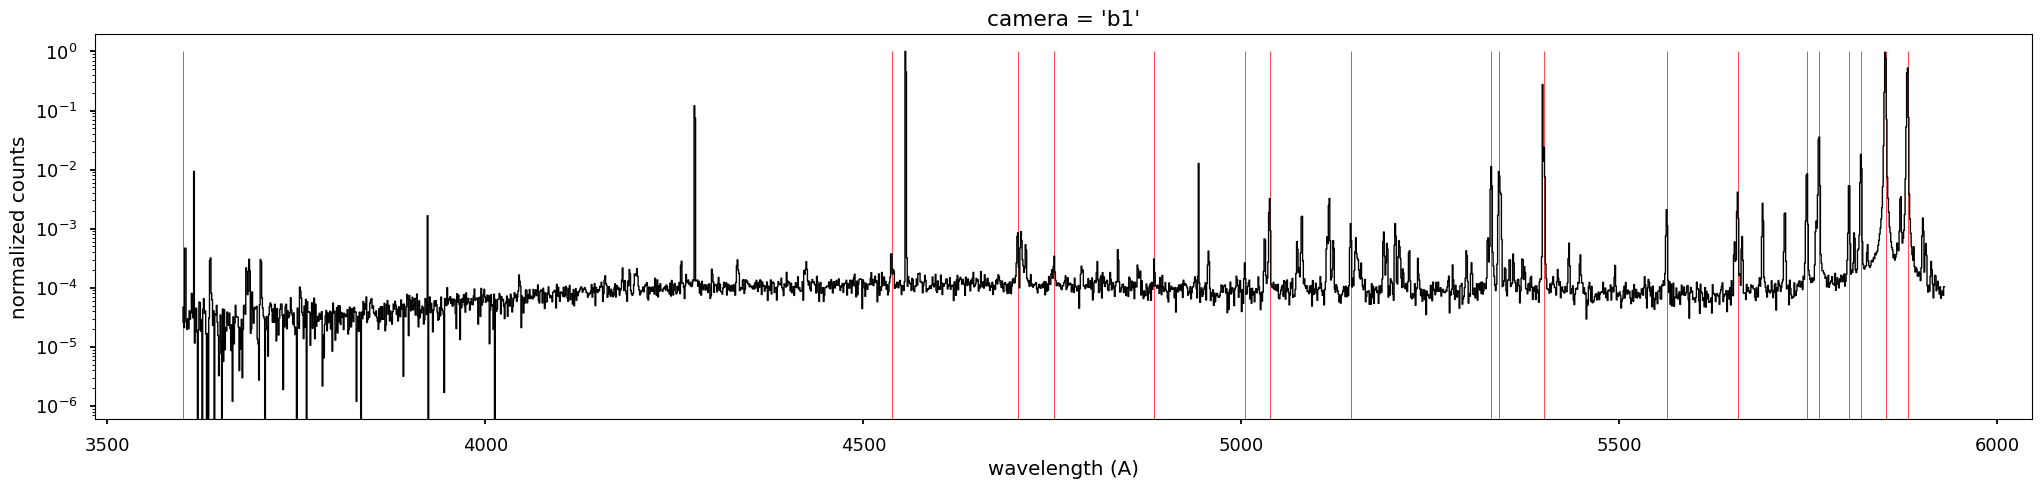

In [38]:
camera = "b1"

harc = rss.RSS()
harc.loadFitsData(out_main_path.format(kind="harc", camera=camera, expnum=arc_expnum, ext="fits"))

# with open(out_main_path.format(kind="pixwave", camera=camera, expnum=arc_expnum, ext="txt")) as f:
with open(f"../../python/lvmdrp/etc/lvm-{lamps}_nist_{camera}.txt") as f:
    f.readline()
    lines_wav = []
    for line in f.readlines():
        _, line_wav, _ = line[:-1].split()
        lines_wav.append(float(line_wav))
    lines_wav = np.asarray(lines_wav)
    lines_int = np.ones_like(lines_wav)
    lines_min = np.zeros_like(lines_wav)

plt.figure(figsize=(25,5))
plt.vlines(lines_wav, lines_min, lines_int / lines_int, lw=0.5, ls="-", color="r")
plt.step(harc._wave, harc._data[ised]/np.nanmax(harc._data[ised]), color="k", lw=1)
plt.gca().set_yscale("log")
plt.xlabel("wavelength (A)")
plt.ylabel("normalized counts")
plt.title(f"{camera = }")
# plt.gca().set_yscale("log")

In [39]:
twilights = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00000199")]

for twilight_frame in twilights:
    twilight_path = twilight_frame["path"]
    twilight_camera, twilight_expnum = twilight_frame["camera"], twilight_frame["expnum"]
    
    # if arc_camera == "b1": continue
    
    wave_range = CHANNEL_WL[twilight_camera]

    imageMethod.preprocRawFrame_drp(
        in_image=twilight_path,
        out_image=out_main_path.format(kind="ptwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        subtract_overscan=True, unit="electron", compute_error=True,
        os_bound_y="1,4080", os_bound_x="2044,2077",
        assume_imagetyp="twilight"
    )
    # imageMethod.LACosmic_drp(
    #     in_image=out_main_path.format(kind="ptwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
    #     out_image=out_main_path.format(kind="rtwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
    #     iter=3, increase_radius=1, flim=1.3, parallel="auto"
    # )
    imageMethod.basicCalibration_drp(
        in_image=out_main_path.format(kind="ptwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        out_image=out_main_path.format(kind="ctwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        in_bias=out_calib_path.format(mjd=60010, kind="mbias", camera=twilight_camera, exptime=0, ext="fits"),
        in_dark=out_calib_path.format(mjd=60010, kind="mdark", camera=twilight_camera, exptime=300, ext="fits")
    )
    
    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="ctwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xtwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=twilight_camera, expnum="ldls", ext="fits"),
        method="aperture", aperture=4, plot=1, parallel="auto"
    )
    
    rssMethod.createPixTable_drp(
        in_rss=out_main_path.format(kind="xtwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="wtwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        arc_wave=out_main_path.format(kind="wave", camera=twilight_camera, expnum=arc_expnum, ext="fits"),
        arc_fwhm=out_main_path.format(kind="lsf", camera=twilight_camera, expnum=arc_expnum, ext="fits")
    )
    
    rssMethod.resampleWave_drp(
        in_rss=out_main_path.format(kind="wtwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="htwilight", camera=twilight_camera, expnum=twilight_expnum, ext="fits"),
        start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
        err_sim=10, parallel="auto", extrapolate=True
    )

[INFO]: using given overscan region Y = ['1', '4080'], X = ['2044', '2077']
[WARNING]: assuming 'TRIMSEC' YX_i = (['1', '4080'], ['1', '2043']), YX_f = (['1', '4080'], ['2078', '4120'])
[INFO]: median counts in overscan sections {'a': 999.0, 'b': 1000.0, 'c': 999.0, 'd': 999.0}
[INFO]: standard deviation in overscan sections {'a': 0.7362346, 'b': 0.7825273, 'c': 0.71679294, 'd': 0.76359147}
[INFO]: extracted gain values 'GAIN' = {'a': 2.71, 'b': 2.71, 'c': 2.68, 'd': 2.69}
[INFO]: extracted rdnoise values 'RDNOISE' = {'a': 3.0, 'b': 3.0, 'c': 2.8, 'd': 2.8}
[INFO]: converting from ADU to e-
[INFO]: calculated Poisson errors for amplifier 'a'
[INFO]: calculated Poisson errors for amplifier 'b'
[INFO]: calculated Poisson errors for amplifier 'c'
[INFO]: calculated Poisson errors for amplifier 'd'
[INFO]: flipping along X-axis
[INFO]: building pixel mask
[INFO]: 10400116 (62 %) pixels masked
[INFO]: updating header and writing pre-processed frame to './data/lvm-ptwilight-b1-00000199.fits'

Text(0, 0.5, 'counts (e-/pix)')

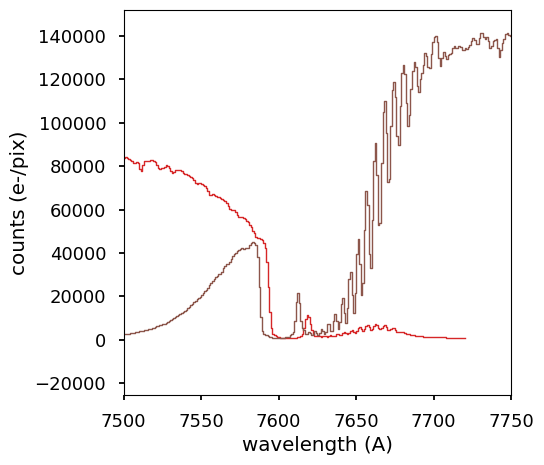

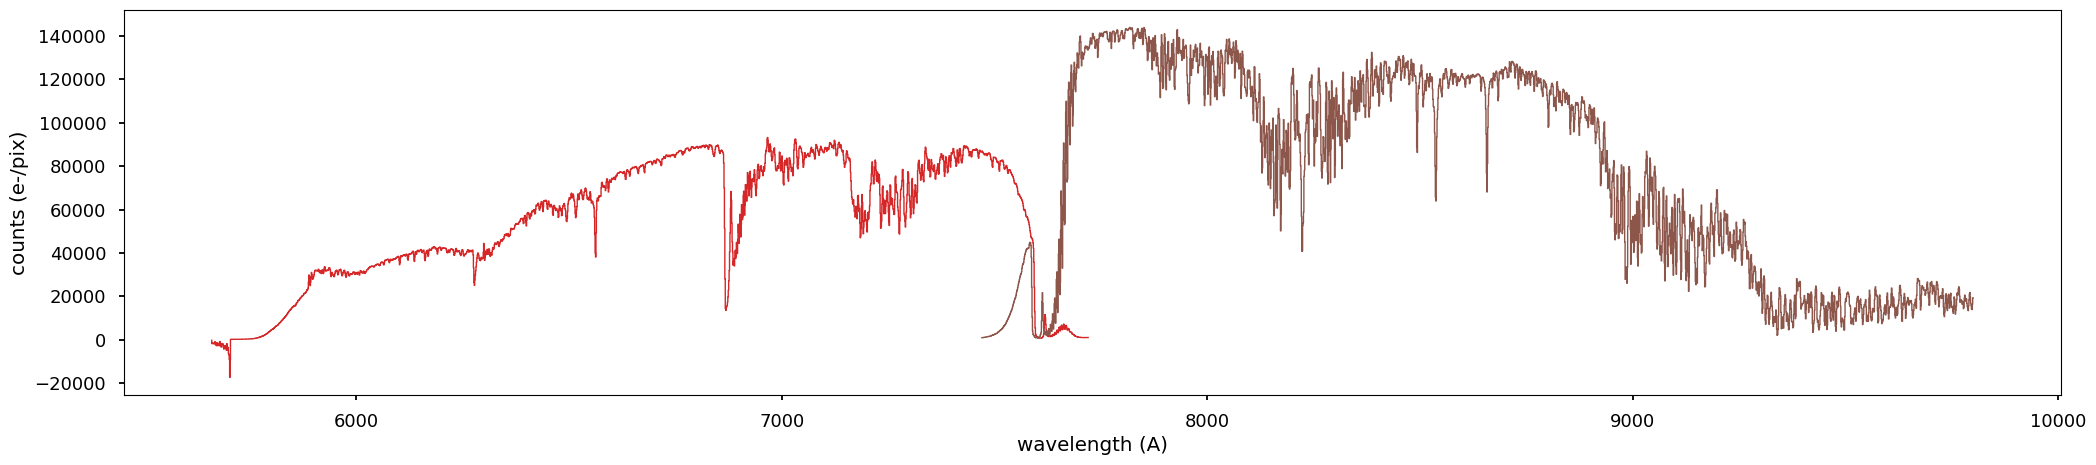

In [40]:
twilight_b = rss.RSS()
twilight_b.loadFitsData(out_main_path.format(kind="htwilight", camera="b1", expnum=twilight_expnum, ext="fits"))
superflat_b = twilight_b.create1DSpec()

twilight_r = rss.RSS()
twilight_r.loadFitsData(out_main_path.format(kind="htwilight", camera="r1", expnum=twilight_expnum, ext="fits"))
superflat_r = twilight_r.create1DSpec()

twilight_z = rss.RSS()
twilight_z.loadFitsData(out_main_path.format(kind="htwilight", camera="z1", expnum=twilight_expnum, ext="fits"))
superflat_z = twilight_z.create1DSpec()

plt.figure(figsize=(5,5))
plt.step(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.step(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.xlim(7500,7750)
plt.xlabel("wavelength (A)")
plt.ylabel("counts (e-/pix)")

plt.figure(figsize=(25,5))
plt.step(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
plt.step(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
plt.xlabel("wavelength (A)")
plt.ylabel("counts (e-/pix)")

In [41]:
# plt.figure(figsize=(25,5))
# for camera in ["b1", "r1", "z1"]:
#     fluxCalMethod.createSensFunction_drp(
#         out_main_path.format(kind="htwilight", camera=camera, expnum=twilight_expnum, ext="fits"),
#         out_main_path.format(kind="throughput", camera=camera, expnum=twilight_expnum, ext="fits"),
#         extinct_curve="Paranal",
#         ref_spec="../../python/lvmdrp/resources/sun.txt", column_wave=0, column_flux=1, header=0, ref_units=1,
#         median_filt=0, smooth_poly=3,
#         airmass=1.2,
#         exptime=240,
#         target_units=1,
#         verbose=False
#     )

#     sens = spectrum1d.Spectrum1D()
#     sens.loadFitsData(out_main_path.format(kind="throughput", camera=camera, expnum=twilight_expnum, ext="fits"))
#     plt.semilogy(sens._wave[~sens._mask], 1/sens._data[~sens._mask])

# plt.xlabel("wavelength (A)")
# plt.ylabel("sensitivity")

# sens_r = spectrum1d.Spectrum1D()
# sens_r.loadFitsData(out_main_path.format(kind="throughput", camera="r1", expnum=twilight_expnum, ext="fits"))

# sens_z = spectrum1d.Spectrum1D()
# sens_z.loadFitsData(out_main_path.format(kind="throughput", camera="z1", expnum=twilight_expnum, ext="fits"))

# sun = Sun.from_default()
# sun_spec = spectrum1d.Spectrum1D(data=sun.fluxd.to("erg/(s cm2 AA)").value, wave=sun.wave.to("AA").value)
# sun_r = sun_spec.resampleSpec(sens_r._wave)
# sun_z = sun_spec.resampleSpec(sens_z._wave)

# plt.figure(figsize=(25,5))
# plt.semilogy(superflat_r._wave, superflat_r._data, color="tab:red", lw=1)
# plt.semilogy(sens_r._wave[~sens_r._mask], (sun_r._data/sens_r._data)[~sens_r._mask])
# plt.semilogy(superflat_z._wave, superflat_z._data, color="tab:brown", lw=1)
# plt.semilogy(sens_z._wave[~sens_z._mask], (sun_z._data/sens_z._data)[~sens_z._mask])


In [48]:
mdark_exptimes = [int(mdark_file.split(".")[0].split("-")[-1]) for mdark_file in os.listdir(output_path) if "mdark" in mdark_file]

# for expnum in range(201, 213):
for expnum in list(range(606,612)) + [676,677,678]:
    objects = frames_groups[(unique_groups["imagetyp"]=="object")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="{:08d}".format(expnum))]
    objects.pprint(max_width=200)

    for object_frame in objects:
        object_path = object_frame["path"]
        object_camera, object_expnum = object_frame["camera"], object_frame["expnum"]
        
        mdark_exptime = np.min(np.abs(object_frame["exptime"]-mdark_exptimes))
        wave_range = CHANNEL_WL[object_camera]

        imageMethod.preprocRawFrame_drp(
            in_image=object_path,
            out_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            subtract_overscan=True, unit="electron", compute_error=True,
            os_bound_y="1,4080", os_bound_x="2044,2077",
            assume_imagetyp="object"
        )
        # imageMethod.LACosmic_drp(
        #     in_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
        #     out_image=out_main_path.format(kind="robject", camera=object_camera, expnum=object_expnum, ext="fits"),
        #     iter=3, increase_radius=1, flim=1.3, parallel="0"
        # )
        imageMethod.basicCalibration_drp(
            in_image=out_main_path.format(kind="pobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            out_image=out_main_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            in_bias=out_calib_path.format(mjd=60039, kind="mbias", camera=object_camera, exptime=0, ext="fits"),
            # in_dark=out_calib_path.format(mjd=60040, kind="mdark", camera=object_camera, exptime=900, ext="fits")
        )

        imageMethod.extractSpec_drp(
            in_image=out_main_path.format(kind="cobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            out_rss=out_main_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            in_trace=out_main_path.format(kind="trace", camera=object_camera, expnum="ldls", ext="fits"),
            method="aperture", aperture=4, plot=1, parallel="auto"
        )

        rssMethod.createPixTable_drp(
            in_rss=out_main_path.format(kind="xobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            out_rss=out_main_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            arc_wave=out_main_path.format(kind="wave", camera=object_camera, expnum=arc_expnum, ext="fits"),
            arc_fwhm=out_main_path.format(kind="lsf", camera=object_camera, expnum=arc_expnum, ext="fits")
        )

        rssMethod.resampleWave_drp(
            in_rss=out_main_path.format(kind="wobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            out_rss=out_main_path.format(kind="hobject", camera=object_camera, expnum=object_expnum, ext="fits"),
            start_wave=wave_range[0], end_wave=wave_range[1], disp_pix=1.0, method="linear",
            err_sim=10, parallel="auto", extrapolate=True
        )

imagetyp spec  mjd  camera  expnum  exptime argon  neon  ldls  hgne xenon                                                           path                                                          
-------- ---- ----- ------ -------- ------- ----- ----- ----- ----- ----- ------------------------------------------------------------------------------------------------------------------------
  object  sp1 60040     b1 00000606   900.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60040/sdR-s-b1-00000606.fits.gz
  object  sp1 60040     r1 00000606   900.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60040/sdR-s-r1-00000606.fits.gz
  object  sp1 60040     z1 00000606   900.0 False False False False False /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/sas/sdsswork/data/lvm/lco/60040/sdR-s-z1-00000606.fits.gz
[INFO]: using given overs

In [49]:
# object_b = rss.RSS()
# object_b.loadFitsData(out_main_path.format(kind="hobject", camera="b1", expnum=object_expnum, ext="fits"))
# superobject_b = object_b.create1DSpec()
# superobject_b._inst_fwhm = superobject_b._inst_fwhm.mean(axis=0)

# object_r = rss.RSS()
# object_r.loadFitsData(out_main_path.format(kind="hobject", camera="r1", expnum=object_expnum, ext="fits"))
# superobject_r = object_r.create1DSpec()
# superobject_r._inst_fwhm = superobject_r._inst_fwhm.mean(axis=0)

# object_z = rss.RSS()
# object_z.loadFitsData(out_main_path.format(kind="hobject", camera="z1", expnum=object_expnum, ext="fits"))
# superobject_z = object_z.create1DSpec()
# superobject_z._inst_fwhm = superobject_z._inst_fwhm.mean(axis=0)

# sens_b = spectrum1d.Spectrum1D()
# sens_b.loadFitsData(out_main_path.format(kind="throughput", camera="b1", expnum=twilight_expnum, ext="fits"))
# sens_r = spectrum1d.Spectrum1D()
# sens_r.loadFitsData(out_main_path.format(kind="throughput", camera="r1", expnum=twilight_expnum, ext="fits"))
# sens_z = spectrum1d.Spectrum1D()
# sens_z.loadFitsData(out_main_path.format(kind="throughput", camera="z1", expnum=twilight_expnum, ext="fits"))

# # superobject_b *= sens_b
# # superobject_r *= sens_r
# # superobject_z *= sens_z

# superobject = superobject_b.coaddSpec(superobject_r).coaddSpec(superobject_z)

# plt.figure(figsize=(25,5))
# # plt.step(superobject_r._wave, superobject_r._data, color="tab:red", lw=1)
# # plt.step(superobject_z._wave, superobject_z._data, color="tab:brown", lw=1)
# # plt.vlines(wave_lines, 0, 1e5, lw=1, color="tab:red")
# plt.axvline(5007)
# plt.step(superobject._wave, superobject._data, color="0.2", lw=1)
# plt.gca().set_yscale("log")
# # plt.ylim(-500, 3000)
# # plt.xlim(5900, 9700)
# plt.xlabel("wavelength (A)")
# plt.ylabel("counts (e-/pix)")
# plt.title(f"{object_expnum = }")

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


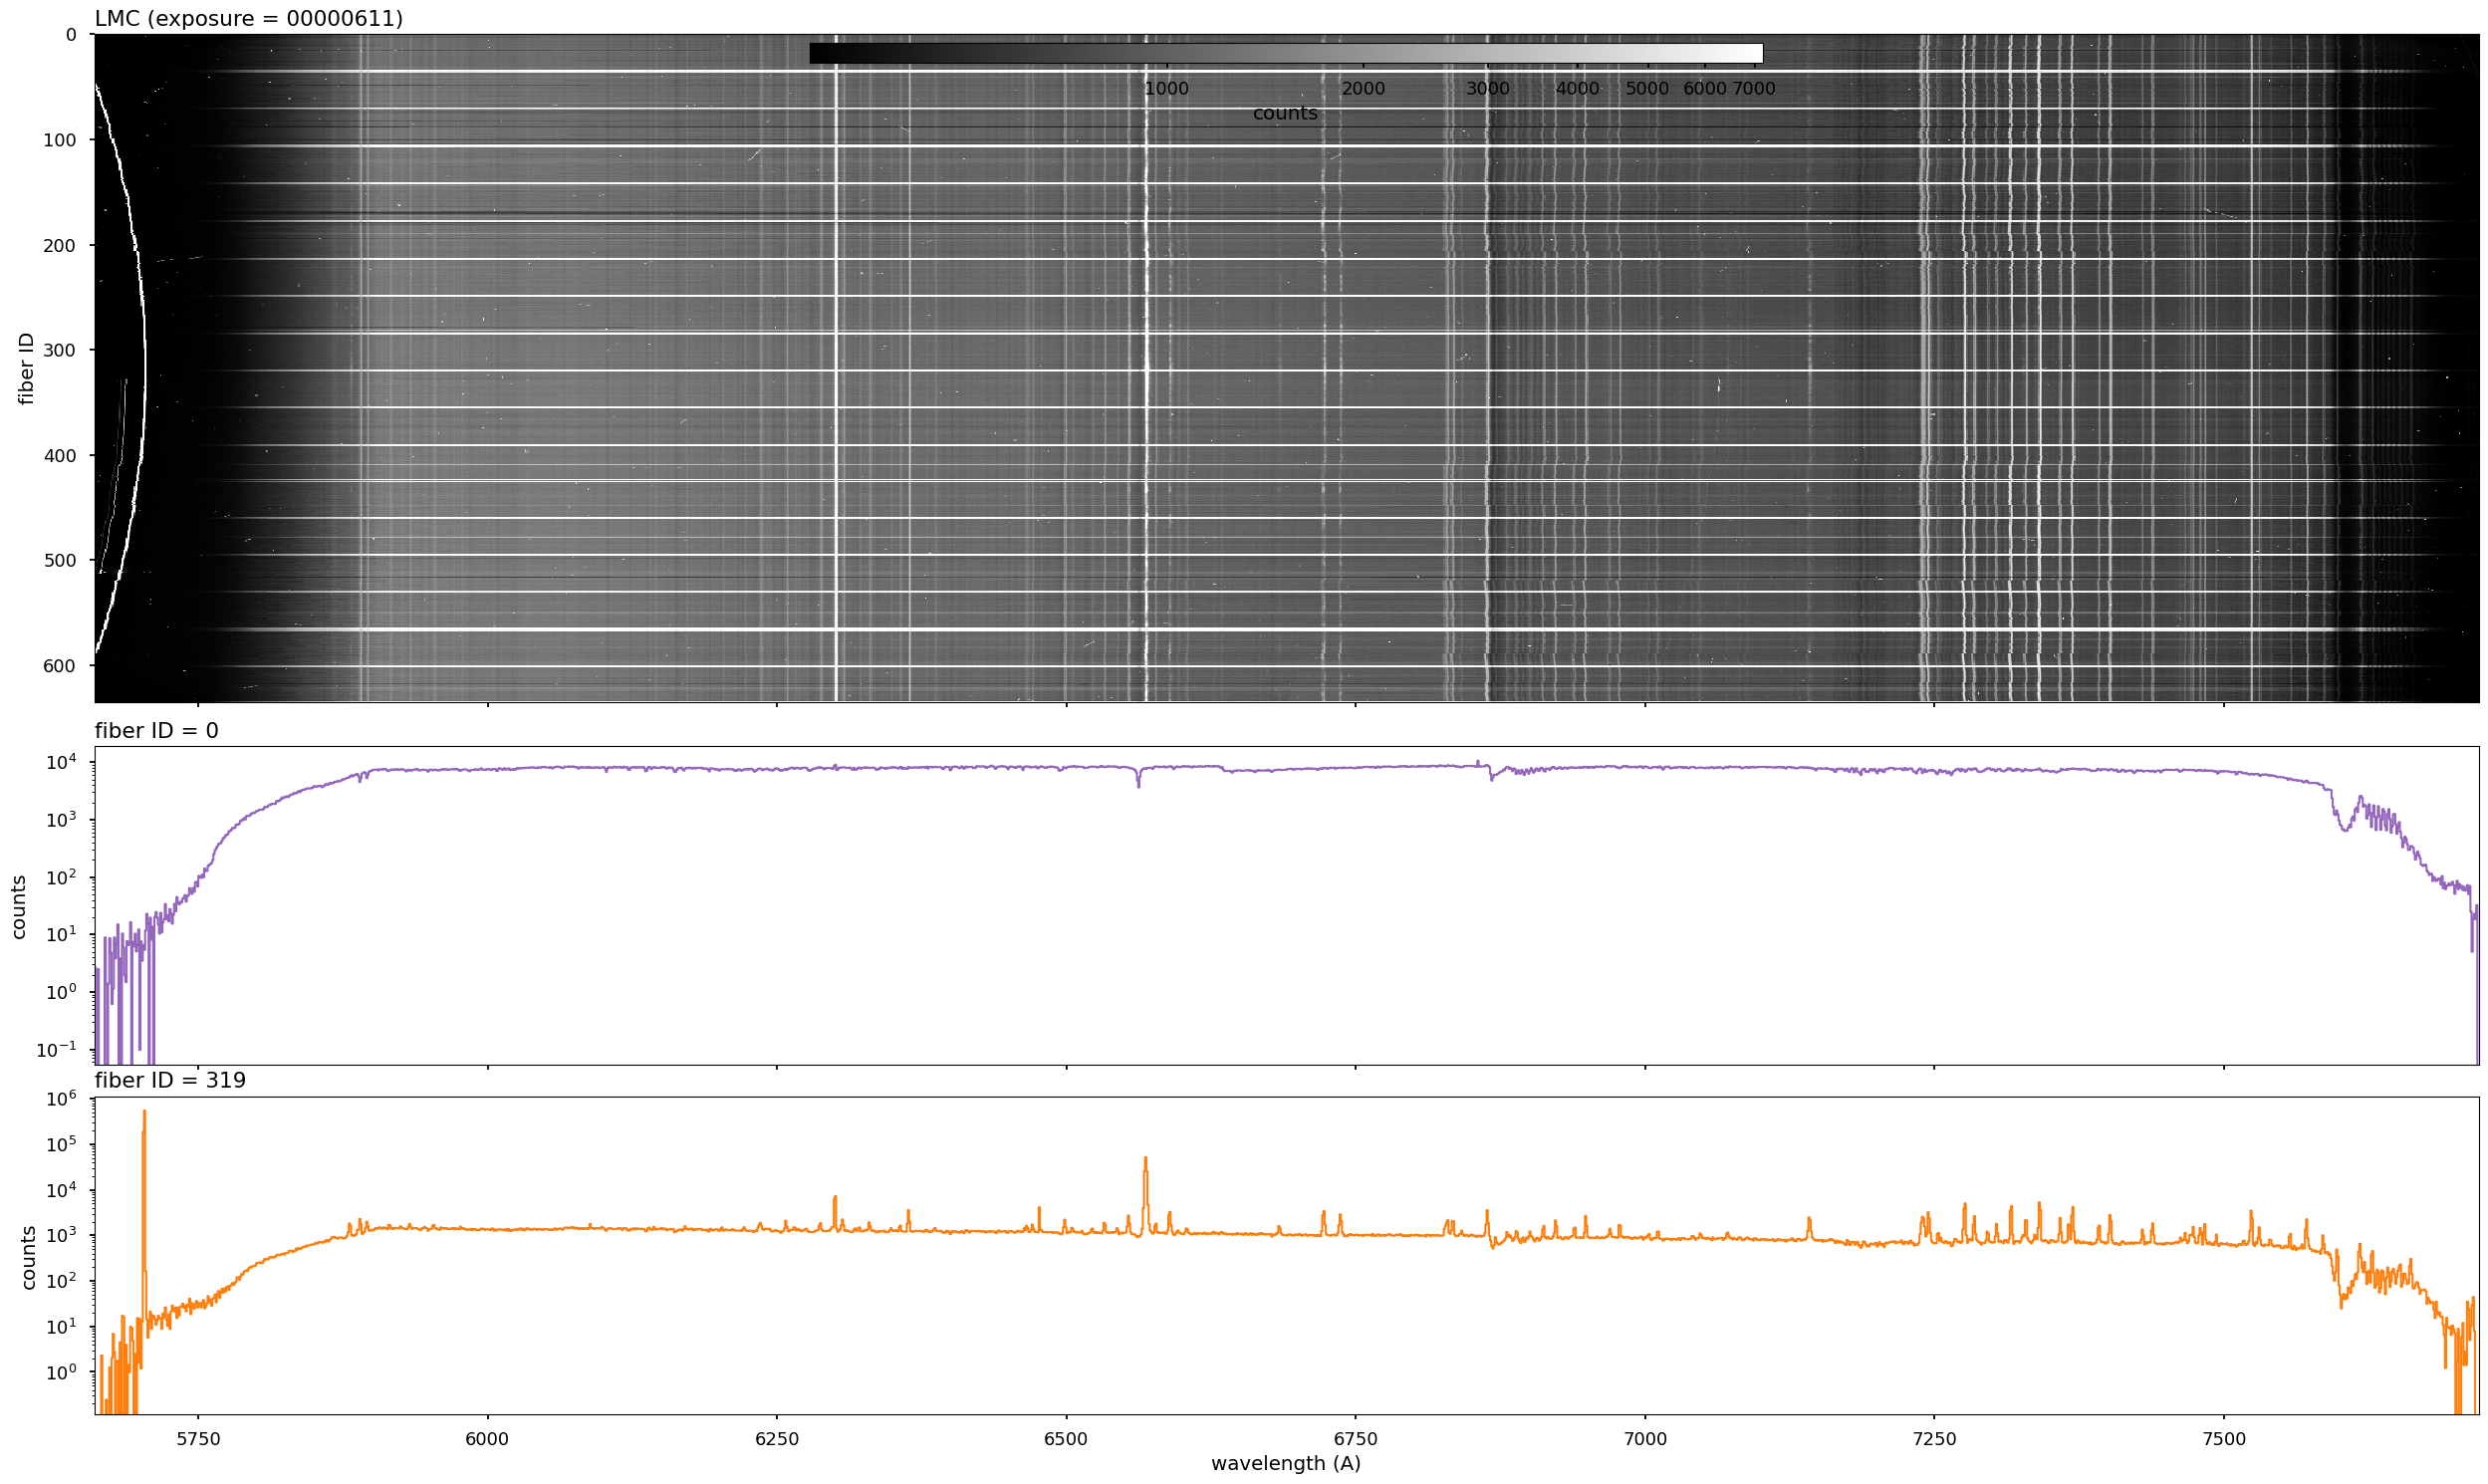

In [51]:
wave_lines, name_lines = np.loadtxt("../../../../lvm-dap/_fitting-data/_configs/MaNGA/emission_lines_long_list.MaNGA", dtype=str, unpack=True)
wave_lines = wave_lines.astype(float)

object_name = "LMC"
object_expnum = "00000611"
object_camera = "r1"

object_r = rss.RSS()
object_r.loadFitsData(out_main_path.format(kind="hobject", camera=object_camera, expnum=object_expnum, ext="fits"))

data = object_r._data
wave = object_r._wave

fiber_1 = 0
fiber_2 = 319
xmin, xmax = data.shape[0], 0
ymin, ymax = wave.min(), wave.max()

fig, (ax1, ax_neb) = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=False)
ax1_divider = make_axes_locatable(ax_neb)
ax_ste = ax1_divider.append_axes("bottom", size="100%", pad="10%")
ax_ste.sharex(ax_neb)
ax_neb.tick_params(labelbottom=False)

norm = ImageNormalize(data, interval=PercentileInterval(95), stretch=AsinhStretch())
im1 = ax1.imshow(data, extent=(ymin,ymax,xmin,xmax), origin="lower", cmap=plt.cm.gray, norm=norm, interpolation="none", aspect="auto")

ax_neb.step(wave, data[fiber_1], color="tab:purple", lw=1.5)
ax_ste.step(wave, data[fiber_2], color="tab:orange", lw=1.5)

axins1 = inset_axes(ax1, width="40%", height="3%", loc="upper center")
axins1.xaxis.set_ticks_position("bottom")
cba = fig.colorbar(im1, cax=axins1, orientation="horizontal")

# ax_neb.set_xlim(5900, 7500)
# ax_ste.set_ylim(2e3, ax_ste.get_ylim()[1])
ax_ste.set_yscale("log")
ax_neb.set_yscale("log")

ax1.set_title(f"{object_name} (exposure = {object_expnum})", loc="left")
ax_neb.set_title(f"fiber ID = {fiber_1}", loc="left")
ax_ste.set_title(f"fiber ID = {fiber_2}", loc="left")
ax1.set_ylabel("fiber ID")
ax_neb.set_ylabel("counts")
ax_ste.set_ylabel("counts")
ax_ste.set_xlabel("wavelength (A)")
cba.set_label("counts")
fig.tight_layout()
fig.savefig(f".figures/lvm-{object_name}-{object_expnum}-{object_camera}.png", bbox_inches="tight")